In [1]:
import torch
import os
import sys
import copy

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import networkx as nx

In [6]:
from torch_scatter import scatter_max, scatter_mean, scatter_min
from functools import lru_cache
from sklearn.model_selection import StratifiedKFold

In [7]:
import wandb

In [8]:
device = "cuda:0"

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [11]:
results_dir = os.path.join('results','e7')
os.makedirs(results_dir, exist_ok=True)

In [12]:
from src.cv import crossvalidation, build_masks
from src.trainer import trainer
from src.cv import reset_model

In [13]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

In [14]:
config = {
    "custom_optimizer": torch.optim.Adam,
    "lr" : 0.01,
    'epochs': 3000,
    'linear_layers': 2,
    'hidden_channels': 8,
    'dropout': 0.5,
    'test-percent': 30,
    'building_buffer': 20,
    'neighbor_radius': 100,
    'n_cv': 3,
    'cv_size': 600
}

In [15]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "w")
f.write(str("Config:\n"))
f.write(str(config))
f.close()

In [16]:
def pool_adjacency(graph, graph_auxillary):
    """Pools environmental features from the region for their use with regression"""
    # energy = scatter_mean(graph['footprint'].y, torch.tensor(graph_auxillary['rebuild_idx']).to(device))
    energy = graph['footprint'].y
    links = graph['footprint','contains','pano']['edge_index']
    features = scatter_mean(graph['pano'].x[links[1]], links[0], dim=0).detach().cpu().numpy()
    features_max = scatter_max(graph['pano'].x[links[1]], links[0], dim=0)[0].detach().cpu().numpy()
    features_min = scatter_min(graph['pano'].x[links[1]], links[0], dim=0)[0].detach().cpu().numpy()
    
    featurenames = graph_auxillary['node_data'].columns
    featuremin = featurenames + '_min'
    featuremax = featurenames + '_max'
    
    featuresdf = pd.DataFrame(graph['pano'].x.detach().cpu().numpy(), columns = featurenames)
    featuresdfmax = pd.DataFrame(features_max, columns = featuremax)
    featuresdfmin = pd.DataFrame(features_min, columns = featuremin)
    return graph_auxillary['footprints'].join(featuresdf).join(featuresdfmax).join(featuresdfmin)

In [17]:
config['test-percent'] = 12
config['building_buffer'] = 90

In [18]:
from src.graph_construction import graph
g1, g1a = graph(
    "new-york",
    neighbor_radius=150,
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

g1p = pool_adjacency(g1, g1a)

In [19]:
g1a['normalization']

{'node': (tensor([ 0.2469,  0.0666, 16.3572], device='cuda:0'),
  tensor([0.0994, 0.0940, 7.1519], device='cuda:0')),
 'building': (tensor([   8.8715, 2789.5448, 4787.4804], device='cuda:0', dtype=torch.float64),
  tensor([  0.7695, 569.7795, 565.1110], device='cuda:0', dtype=torch.float64))}

In [20]:
g2, g2a = graph(
    "san-francisco",
    neighbor_radius=150,
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)

g2p = pool_adjacency(g2, g2a)

g3, g3a = graph(
    "austin",
    neighbor_radius=150,
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)

g3p = pool_adjacency(g3, g3a)

<AxesSubplot: >

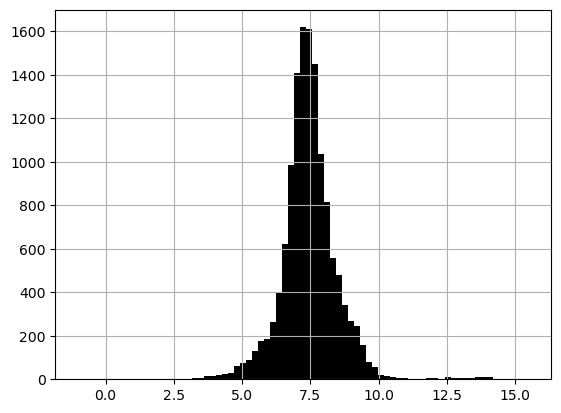

In [21]:
np.log(g1a['footprints'].energy).hist(bins=75, color="black")

In [22]:
g1p.drop(columns=["id","geometry","year"]).describe()

,energy,area,hdd,cdd,sky_area,vegetation_area,car_count,sky_area_max,vegetation_area_max,car_count_max,sky_area_min,vegetation_area_min,car_count_min
count,1.337600e+04,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000,13376.000000
mean,9.209194e+03,9714.055301,2789.544821,4787.480406,-0.218543,0.039085,0.167481,0.834190,2.268015,1.745108,-1.794282,-0.700060,-1.229836
std,1.170891e+05,8865.916754,569.779499,565.110994,0.919349,1.006770,0.953370,0.629088,1.314018,0.884880,0.731867,0.115397,0.574233
min,3.597384e-01,27.870939,185.345664,2183.403795,-2.482980,-0.707984,-2.287128,-2.445945,-0.707984,-2.287128,-2.484289,-0.707984,-2.287128
25%,1.039547e+03,4172.906660,2486.595420,4423.442154,-0.777968,-0.707984,-0.469419,0.395818,1.319543,1.208466,-2.363571,-0.707984,-1.588009
50%,1.664815e+03,6564.209998,2923.122415,4792.310435,-0.176822,-0.377560,0.089876,0.898009,2.541590,1.627937,-2.101506,-0.707984,-1.168538
75%,2.867630e+03,11528.651325,3182.745323,5157.548803,0.410133,0.390646,0.788994,1.299562,3.324472,2.327056,-1.349048,-0.707984,-0.888891
max,5.376747e+06,50304.071944,4149.092892,7351.370592,2.200790,5.028328,4.704060,2.412033,5.850718,4.983707,1.908834,3.081732,2.466880


In [23]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(g1p.drop(columns=["id","geometry","year"]).describe())

            energy      area       hdd       cdd  sky_area  vegetation_area  \
count    13,376.00 13,376.00 13,376.00 13,376.00 13,376.00        13,376.00   
mean      9,209.19  9,714.06  2,789.54  4,787.48     -0.22             0.04   
std     117,089.12  8,865.92    569.78    565.11      0.92             1.01   
min           0.36     27.87    185.35  2,183.40     -2.48            -0.71   
25%       1,039.55  4,172.91  2,486.60  4,423.44     -0.78            -0.71   
50%       1,664.81  6,564.21  2,923.12  4,792.31     -0.18            -0.38   
75%       2,867.63 11,528.65  3,182.75  5,157.55      0.41             0.39   
max   5,376,747.40 50,304.07  4,149.09  7,351.37      2.20             5.03   

       car_count  sky_area_max  vegetation_area_max  car_count_max  \
count  13,376.00     13,376.00            13,376.00      13,376.00   
mean        0.17          0.83                 2.27           1.75   
std         0.95          0.63                 1.31           0.88   
min     

In [24]:
# from src.graph_construction import graph
# g1, g1a = graph(
#     "new-york",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )
# trainids, testids = build_corpus(g1, g1a)

# # nycgraph = transform(nycgraph)

In [25]:
idpool = g1a['footprints'].id
idtrain = idpool[g1a['training_mask'].detach().cpu().numpy()]
idtest = idpool[g1a['test_mask'].detach().cpu().numpy()]

### at this point, starting to train the model based on the new york data. m1 will be the linear model with no auxillary features, m2 will be the remote sensing data, m3 will be the comprehensive data

In [26]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("NY Graph:\n"))
f.write(str(g1))
f.close()

In [27]:
from sklearn.model_selection import KFold

def build_corpus(g1, g1a):
    trainids = []
    testids = []

    training_corpus = pool_adjacency(g1, g1a).iloc[g1a['training_mask'].detach().cpu().numpy()].reset_index(drop=True)

    kf = KFold(n_splits=7)
    for train, test in kf.split(training_corpus):
        trainids.append(training_corpus.id[train])
        testids.append(training_corpus.id[test])
        
    return trainids, testids

In [28]:
750 / 25

30.0

In [29]:
# distances = np.linspace(config['building_buffer'], 1000, 10)

In [30]:
distances = np.logspace(np.log10(config['building_buffer']), np.log10(1000), 100)

In [31]:
# print(f"N Training: {len(trainids[0])}\nN Testing: {len(testids[0])}")

In [32]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [33]:
import matplotlib as mpl
mpl.rc('image', cmap='Set1')


In [34]:
import seaborn as sns
sns.set(style='ticks', palette='Dark2')

In [35]:
# print(f"Losses:\n\nM1: {m1_rmse:,.2f}\nM2: {m2_rmse:,.2f}\nM3: {m3_rmse:,.2f}")

In [36]:
# print(f"Losses:\n\nM4: {m4_rmse:,.2f}\nM5: {m5_rmse:,.2f}\nM6: {m6_rmse:,.2f}")

In [37]:
# np.mean(losses) / 1e6

In [38]:
# np.mean(abslosses)

In [39]:
# from src.graph_construction import graph
# sfgraph, sf_rebuild_info = graph(
#     "san-fransisco",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [40]:
# f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
# f.write(str("\n\n"))
# f.write(str("San Fransisco Graph:\n"))
# f.write(str(sfgraph))
# f.close()

In [41]:
# from src.graph_construction import graph
# austingraph, austin_rebuild_info = graph(
#     "austin",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [42]:
# f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
# f.write(str("\n\n"))
# f.write(str("Austin Graph:\n"))
# f.write(str(austingraph))
# f.close()

In [43]:
(~g1a['training_mask']).sum()

tensor(1605, device='cuda:0')

In [44]:
g1a['training_mask'].sum()

tensor(11771, device='cuda:0')

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
loss_func = torch.nn.MSELoss()

In [47]:
nyc_mask = g1a['training_mask'].cpu().numpy()

In [48]:
int(nyc_mask.sum() * 0.1)

1177

In [49]:
config['cv_size'] = int(nyc_mask.sum() * 0.1)
config['cv_size']

1177

In [59]:
np.random.seed(1)
torch.manual_seed(1)
nyc_cvs = build_masks(
    nyc_mask, 
    n_cv = 8,
    n_val = config['cv_size']
)

In [60]:
valmean = []
valstd = []

trainmean = []
trainstd = []

nyX = g1['footprint'].x.detach().cpu().numpy()
nyY = g1['footprint'].y.cpu()

cvtrain_errors = []
cv_errors = []
for crossfold in nyc_cvs:
    nytrain, nyval = crossfold

    reg = LinearRegression().fit(nyX[nytrain], nyY[nytrain])
    overfitpred = reg.predict(nyX[nytrain])
    fitpred = reg.predict(nyX[nyval])

    overfitloss = float(loss_func(torch.tensor(overfitpred), nyY[nytrain]))
    regloss = float(loss_func(torch.tensor(fitpred), nyY[nyval]))

    cvtrain_errors.append(overfitloss)
    cv_errors.append(regloss)

linear_regtrainerr = np.mean(cvtrain_errors)
linear_regerr = np.mean(cv_errors)

trainmean.append(linear_regtrainerr)
valmean.append(linear_regerr)

trainstd.append(np.std(cvtrain_errors))
valstd.append(np.std(cv_errors))

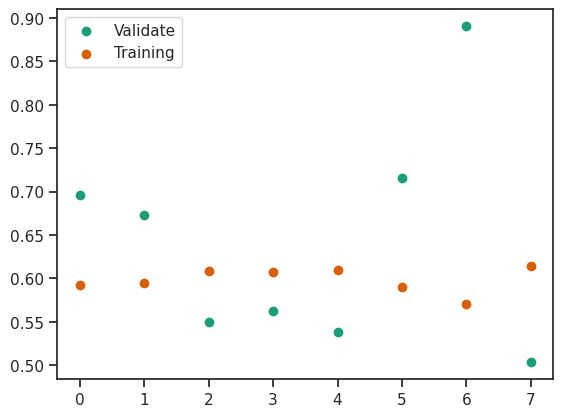

In [61]:
plt.scatter(range(len(cv_errors)), cv_errors, label="Validate")
plt.scatter(range(len(cvtrain_errors)), cvtrain_errors, label="Training")
plt.legend()

In [62]:
trainmean

[0.5987235680222511]

In [63]:
valmean

[0.6410418525338173]

In [64]:
fullreg = LinearRegression().fit(nyX, nyY)

In [65]:
# plt.plot(range(ntesting), trainmean, label="training")
# plt.fill_between(
#     range(ntesting), 
#     np.array(trainmean) - np.array(trainstd), 
#     np.array(trainmean) + np.array(trainstd),
#     alpha=0.2
# ) 

# plt.plot(range(ntesting), valmean, label="validation")
# plt.fill_between(
#     range(ntesting), 
#     np.array(valmean) - np.array(valstd), 
#     np.array(valmean) + np.array(valstd),
#     alpha=0.2
# )

# plt.ylim(0.3, 1.3)
# plt.legend()
# plt.show()

In [66]:
g1['footprint'].x.shape[1]

3

In [67]:
config['epochs'] = int(1e3)
config['lr'] = 0.01

In [68]:
g1['footprint'].x

tensor([[-0.4651, -2.0440,  1.0195],
        [ 0.2711, -1.9341,  0.9948],
        [-0.0047, -1.4924,  0.9087],
        ...,
        [-2.1875, -0.2102,  0.4811],
        [ 1.9599, -0.7411,  0.1651],
        [-2.3068,  1.0602, -2.6950]], device='cuda:0')

In [69]:
g1a['footprints'].drop(columns=["id","geometry","year"])

,energy,area,hdd,cdd
0,1022.022331,4982.209051,1624.918473,5363.637485
1,1976.070202,8779.345776,1687.509132,5349.625418
2,1661.980018,7100.586219,1939.211581,5301.015337
3,2305.142743,11217.588421,2331.513863,5215.119099
4,2928.477275,16722.563383,1912.050834,5314.381368
...,...,...,...,...
13371,60.944476,5295.478405,2462.514850,4917.660529
13372,4136.360394,8953.353338,2388.908408,5245.983291
13373,537.698770,1323.869601,2669.791720,5059.377001
13374,7648.797011,32198.180957,2367.297559,4880.790748


In [70]:
g1['footprint'].y

tensor([6.9295, 7.5889, 7.4158,  ..., 6.2873, 8.9423, 6.6649], device='cuda:0')

In [71]:
np.log(g1a['footprints'].energy)

0        6.929539
1        7.588865
2        7.415765
3        7.742898
4        7.982238
           ...   
13371    4.109963
13372    8.327572
13373    6.287298
13374    8.942304
13375    6.664929
Name: energy, Length: 13376, dtype: float64

In [72]:
config['input_shape'] = g1['footprint'].x.shape[1]

In [73]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485
1,11640540857295396741,"POLYGON ((585824.204 4511010.579, 585801.557 4...",1976.070202,8779.345776,2012,1687.509132,5349.625418
2,4799432601768318575,"POLYGON ((585808.805 4510929.549, 585798.549 4...",1661.980018,7100.586219,2012,1939.211581,5301.015337
3,16920889134437381520,"POLYGON ((585752.965 4510960.067, 585746.097 4...",2305.142743,11217.588421,2012,2331.513863,5215.119099
4,1749360111145323354,"POLYGON ((585856.706 4510950.191, 585830.184 4...",2928.477275,16722.563383,2016,1912.050834,5314.381368
...,...,...,...,...,...,...,...
13371,16695332508867886524,"POLYGON ((587251.112 4506565.198, 587237.835 4...",60.944476,5295.478405,2012,2462.514850,4917.660529
13372,3010589633849135112,"POLYGON ((586796.159 4509068.953, 586792.590 4...",4136.360394,8953.353338,2012,2388.908408,5245.983291
13373,5418421121047772298,"POLYGON ((592755.083 4508579.412, 592751.726 4...",537.698770,1323.869601,2017,2669.791720,5059.377001
13374,1836429563859990194,"POLYGON ((583641.685 4502671.305, 583467.840 4...",7648.797011,32198.180957,2016,2367.297559,4880.790748


In [74]:
from src.model import NullModel

# input_shape = nycgraph['footprint'].x.shape[1]
nullmodel = NullModel(
    layers = config['linear_layers'],
    input_shape = config['input_shape'],
    hidden_channels = config['hidden_channels']
).to(device)

default_nullmodelstate = copy.deepcopy(nullmodel.state_dict())
null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(g1['footprint'].x),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

CV Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [75]:
from src.model import CustomGAT

model = CustomGAT(
    hidden_channels = config['hidden_channels'], 
    out_channels=4,
    layers=1,
    heads=4,
    linear_layers = config['linear_layers'],
    input_shape = config['input_shape'],
    dropout = config['dropout']
).to(device)

default_modelstate = copy.deepcopy(model.state_dict())

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:58: UserWarning: There exist node types ({'pano'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


In [76]:
graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(g1.x_dict, g1.edge_index_dict),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

CV Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [77]:
g1a['footprints'].describe()

,energy,area,year,hdd,cdd
count,1.337600e+04,13376.000000,13376.000000,13376.000000,13376.000000
mean,9.209194e+03,9714.055301,2014.128738,2789.544821,4787.480406
std,1.170891e+05,8865.916754,2.311973,569.779499,565.110994
min,3.597384e-01,27.870939,2012.000000,185.345664,2183.403795
25%,1.039547e+03,4172.906660,2012.000000,2486.595420,4423.442154
50%,1.664815e+03,6564.209998,2012.000000,2923.122415,4792.310435
75%,2.867630e+03,11528.651325,2017.000000,3182.745323,5157.548803
max,5.376747e+06,50304.071944,2017.000000,4149.092892,7351.370592


In [78]:
# g1a['footprints'].explore('energy', control_scale=True)

In [79]:
null_mean_tl = null_training_tensor.mean(axis=0)
null_mean_vl = null_validation_tensor.mean(axis=0)

In [80]:
mean_tl = graph_training_tensor.mean(axis=0)
std_tl = graph_training_tensor.std(axis=0)

mean_vl = graph_validation_tensor.mean(axis=0)
std_vl = graph_validation_tensor.std(axis=0)

# plt.plot(mean_tl, label="Graph Training")
# plt.plot(mean_vl, label="Graph Validation")
# plt.legend()

# plt.yscale("log")
# plt.ylim((0.55,0.65))

# plt.show()

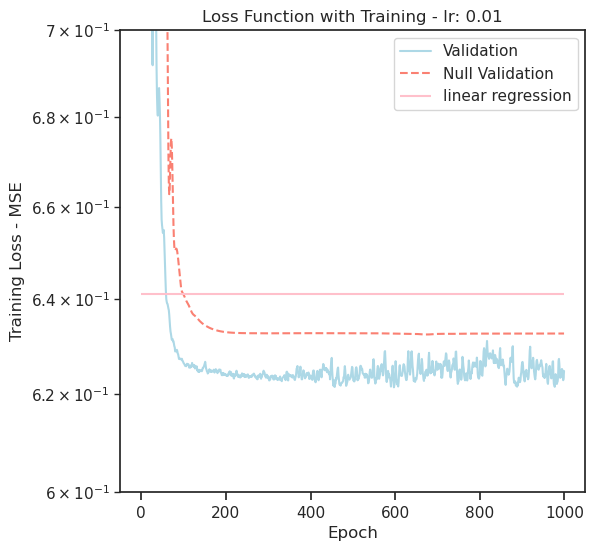

In [88]:
domain = np.arange(0, config['epochs'])
plt.figure(figsize=(6, 6), dpi=100)

# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

plt.yscale("log")
plt.ylim((0.6,0.7))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight")
plt.show()

In [89]:
graph_improvement = (min(mean_vl) - min(null_mean_vl)) / min(null_mean_vl)
print("Improvement from Context: {:0.2f}%".format(100*graph_improvement))

Improvement from Context: -1.75%


In [90]:
# now examining how this may generalize
model.eval()
nullmodel.eval()
with torch.no_grad():
    print("New York City")
    testidx = (~g1a['training_mask']).detach().cpu().numpy()
    # rebuilding_idx = np.array(g1a['rebuild_idx'])

    linear_predictions = reg.predict(g1['footprint'].x.cpu().numpy())[testidx]
    null_predictions = nullmodel(g1['footprint'].x).squeeze()[testidx]
    estimates = model(g1.x_dict, g1.edge_index_dict).squeeze().detach()[testidx]
    recorded = g1['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    
    print("Linear Loss:\t{:0.3f}".format(linear_loss))
    print("Null Loss:\t{:0.3f}".format(null_loss))
    print("Graph Loss:\t{:0.3f}".format(graph_loss))
    print("Improvement:\t{:0.3f}".format(100 * (graph_loss - null_loss)/null_loss))

New York City
Linear Loss:	0.616
Null Loss:	0.601
Graph Loss:	0.602
Improvement:	0.080


In [91]:
linmae = torch.abs(torch.exp(recorded) - torch.tensor(np.exp(linear_predictions)).to(device))
nullmae = torch.abs(torch.exp(recorded) - torch.exp(null_predictions))
graphmae = torch.abs(torch.exp(recorded) - torch.exp(estimates))

In [92]:
def relative_benefit(errors, threshold):
    count_pass = (errors <= threshold).sum()
    return float(100 * (count_pass / len(errors)))

In [96]:
threshold = 100

print(f"Linear Benefit:\t\t{relative_benefit(linmae, threshold):0.2f}")
print(f"Null Benefit:\t\t{relative_benefit(nullmae, threshold):0.2f}")
print(f"Graph Benefit:\t\t{relative_benefit(graphmae, threshold):0.2f}")

Linear Benefit:		13.08
Null Benefit:		14.33
Graph Benefit:		14.45


In [78]:
tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
# tcorp

In [79]:
ESC_CHAR

NameError: name 'ESC_CHAR' is not defined

In [ ]:
## this is now the segment where we explore the utility of various datasets with increasing distance from the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

m1a = []
m2a = []
m3a = []
m4a = []
m5a = []
m6a = []

m1l = []
m2l = []
m3l = []
m4l = []
m5l = []
m6l = []

linearmodel = ElasticNet()
tree = RandomForestRegressor(max_depth = 1, min_samples_leaf=10, n_estimators = 500, random_state = 1, n_jobs = -1)

# starting graph, which defines the test and train ids
g1, g1a = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
trainids, testids = build_corpus(g1, g1a)

for distance in tqdm_notebook(distances):
    g1, g1a = graph(
        "new-york",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=distance,
        test_percent=config['test-percent']
    )
    tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    m1a.append(m1_mae)
    m1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    m2a.append(m2_mae)
    m2l.append(m2_rmse)

    losses, abslosses = custom_cv(linearmodel, tcorp, trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    m3a.append(m3_mae)
    m3l.append(m3_rmse)

    m4_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(tree, tcorp[m4_terms], trainids, testids)
    m4_rmse = np.mean(losses)
    m4_mae = np.mean(abslosses)
    m4a.append(m4_mae)
    m4l.append(m4_rmse)

    m5_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losserandom_state, abslosses = custom_cv(tree, tcorp[m5_terms], trainids, testids)
    m5_rmse = np.mean(losses)
    m5_mae = np.mean(abslosses)
    m5a.append(m5_mae)
    m5l.append(m5_rmse)

    losses, abslosses = custom_cv(tree, tcorp, trainids, testids)
    m6_rmse = np.mean(losses)
    m6_mae = np.mean(abslosses)
    m6a.append(m6_mae)
    m6l.append(m6_rmse)

In [ ]:
n1a = []
n2a = []
n3a = []

n1l = []
n2l = []
n3l = []

# starting graph, which defines the test and train ids
g2, g2a = graph(
    "san-francisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
trainids, testids = build_corpus(g2, g2a)

for distance in tqdm_notebook(distances):
    g2, g2a = graph(
        "san-francisco",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=distance,
        test_percent=config['test-percent']
    )
    tcorp = pool_adjacency(g2, g2a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    n1a.append(m1_mae)
    n1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    n2a.append(m2_mae)
    n2l.append(m2_rmse)

    losses, abslosses = custom_cv(linearmodel, tcorp, trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    n3a.append(m3_mae)
    n3l.append(m3_rmse)

In [ ]:
o1a = []
o2a = []
o3a = []

o1l = []
o2l = []
o3l = []

# starting graph, which defines the test and train ids
g3, g3a = graph(
    "austin",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
trainids, testids = build_corpus(g3, g3a)

for distance in tqdm_notebook(distances):
    g3, g3a = graph(
        "austin",
        neighbor_radius=config['neighbor_radius'],
        building_buffer=distance,
        test_percent=config['test-percent']
    )
    tcorp = pool_adjacency(g3, g3a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    o1a.append(m1_mae)
    o1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    o2a.append(m2_mae)
    o2l.append(m2_rmse)

    losses, abslosses = custom_cv(linearmodel, tcorp, trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    o3a.append(m3_mae)
    o3l.append(m3_rmse)

In [ ]:
import matplotlib as mpl
plt.style.use('fivethirtyeight')

In [ ]:
import scipy.optimize
def parabola(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [ ]:
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3l)

y_fit = parabola(distances, *fit_params)

In [ ]:
# plt.scatter(training_corpus
from csaps import csaps
from scipy.interpolate import splrep, BSpline

s = 0.0001
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)
# Create subplots with shared x-axis

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(8,15))
fig.patch.set_facecolor('white')

ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

# ax.set_color_cycle(sns.color_palette("coolwarm_r",6))

alpha = 0.2

# plt.scatter(distances, m4l, alpha=alpha)
# plt.scatter(distances, m5l, alpha=alpha)
# plt.scatter(distances, m6l, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 300)
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3l)
m_fit = parabola(newdist, *fit_params)

nfit_params, pcov = scipy.optimize.curve_fit(parabola, distances, n3l)
n_fit = parabola(newdist, *nfit_params)

ofit_params, pcov = scipy.optimize.curve_fit(parabola, distances, o3l)
o_fit = parabola(newdist, *ofit_params)

ax1.set_title("Building Buffer vs. RMSE - New York City")
ax1.scatter(distances, m1l, alpha=0)
ax1.scatter(distances, m2l, alpha=0)
ax1.scatter(distances, m3l, alpha=alpha)

ax1.plot(newdist, csaps(distances, m1l, newdist, smooth=s), label="M1")
ax1.plot(newdist, csaps(distances, m2l, newdist, smooth=s), label="M2")
ax1.plot(newdist, m_fit, label="M3")

ax1.set_ylabel('RMSE')

ax2.scatter(distances, n1l, alpha=0)
ax2.scatter(distances, n2l, alpha=0)
ax2.scatter(distances, n3l, alpha=alpha)

ax2.plot(newdist, csaps(distances, n1l, newdist, smooth=s), label="M1")
ax2.plot(newdist, csaps(distances, n2l, newdist, smooth=s), label="M2")
ax2.plot(newdist, n_fit, label="M3")

ax2.set_ylabel('RMSE')

ax3.scatter(distances, o1l, alpha=0)
ax3.scatter(distances, o2l, alpha=0)
ax3.scatter(distances, o3l, alpha=alpha)

ax3.plot(newdist, csaps(distances, o1l, newdist, smooth=s), label="M1")
ax3.plot(newdist, csaps(distances, o2l, newdist, smooth=s), label="M2")
ax3.plot(newdist, o_fit, label="M3")

ax3.set_ylabel('RMSE')

# plt.plot(newdist, csaps(distances, m4l, newdist, smooth=s), label="M4")
# plt.plot(newdist, csaps(distances, m5l, newdist, smooth=s), label="M5")
# plt.plot(newdist, csaps(distances, m6l, newdist, smooth=s), label="M6")

ax3.set_xlabel("Building Buffer (m)")

# plt.title("Building Buffer vs. RMSE - New York City")
# plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

ax1.legend(loc="upper right")

ax1.set_title('New York City')
ax2.set_title('San Francisco')
ax3.set_title('Austin')

plt.savefig(os.path.join(results_dir, "contextual_significance.png"), transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')

ax.set_facecolor('white')
# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

plt.yscale("log")
plt.ylim((0.58,0.62))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
# plt.scatter(training_corpus
from csaps import csaps
from scipy.interpolate import splrep, BSpline

s = 0.001
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)

fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# plt.yscale("log")

alpha = 0.2

# plt.scatter(distances, m1a, alpha=alpha)
# plt.scatter(distances, m2a, alpha=alpha)
# plt.scatter(distances, m3a, alpha=alpha)
plt.scatter(distances, m4a, alpha=alpha)
plt.scatter(distances, m5a, alpha=alpha)
plt.scatter(distances, m6a, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 300)
# plt.plot(newdist, csaps(distances, m1a, newdist, smooth=s), label="M1")
# plt.plot(newdist, csaps(distances, m2a, newdist, smooth=s), label="M2")
# plt.plot(newdist, csaps(distances, m3a, newdist, smooth=s), label="M3")
plt.plot(newdist, csaps(distances, m4a, newdist, smooth=s), label="M4")
plt.plot(newdist, csaps(distances, m5a, newdist, smooth=s), label="M5")
plt.plot(newdist, csaps(distances, m6a, newdist, smooth=s), label="M6")

plt.ylabel("MAE")
plt.xlabel("Building Buffer (m)")

plt.title("Building Buffer vs. MAE - New York City")
plt.ticklabel_format(axis='y', style='sci', scilimits=(2,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

plt.legend(loc="upper right")
plt.savefig(os.path.join(results_dir, "contextual_significance_mae.png"))
plt.show()

In [ ]:
nycfootprints = g1a['footprints']
nycfootprints['logenergy'] = np.log(nycfootprints.energy)

# nycfootprints.explore('logenergy')

In [ ]:
torch.exp(null_predictions)

In [ ]:
testidx = (~g2a['training_mask']).detach().cpu().numpy()
testidx

In [ ]:
rebuilding_idx = np.array(g2a['rebuild_idx'])

In [ ]:
g1a['footprints']

In [97]:
g1, g1a = graph(
    "new-york",
    neighbor_radius=150,
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)
g1a['footprints']['logenergy'] = np.log(g1a['footprints'].energy)

g1p = pool_adjacency(g1, g1a)

In [124]:
## building these using generalization parameters from New York
g2, g2a = graph(
    "san-francisco",
    neighbor_radius=150,
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)
g2a['footprints']['logenergy'] = np.log(g2a['footprints'].energy)
g2p = pool_adjacency(g2, g2a)

g3, g3a = graph(
    "austin",
    neighbor_radius=150,
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent'],
    normalization=g1a['normalization']
)
g3a['footprints']['logenergy'] = np.log(g3a['footprints'].energy)
g3p = pool_adjacency(g3, g3a)

In [99]:
g1a.keys()

dict_keys(['rebuild_idx', 'node_data', 'node_data_original', 'footprints', 'training_mask', 'test_mask', 'normalization'])

In [100]:
g1a['footprints'].logenergy

0        6.929539
1        7.588865
2        7.415765
3        7.742898
4        7.982238
           ...   
13371    4.109963
13372    8.327572
13373    6.287298
13374    8.942304
13375    6.664929
Name: logenergy, Length: 13376, dtype: float64

In [101]:
g1a['footprints']

,id,geometry,energy,area,year,hdd,cdd,logenergy
0,9831628575705046469,"POLYGON ((585927.699 4510953.665, 585901.046 4...",1022.022331,4982.209051,2012,1624.918473,5363.637485,6.929539
1,11640540857295396741,"POLYGON ((585824.204 4511010.579, 585801.557 4...",1976.070202,8779.345776,2012,1687.509132,5349.625418,7.588865
2,4799432601768318575,"POLYGON ((585808.805 4510929.549, 585798.549 4...",1661.980018,7100.586219,2012,1939.211581,5301.015337,7.415765
3,16920889134437381520,"POLYGON ((585752.965 4510960.067, 585746.097 4...",2305.142743,11217.588421,2012,2331.513863,5215.119099,7.742898
4,1749360111145323354,"POLYGON ((585856.706 4510950.191, 585830.184 4...",2928.477275,16722.563383,2016,1912.050834,5314.381368,7.982238
...,...,...,...,...,...,...,...,...
13371,16695332508867886524,"POLYGON ((587251.112 4506565.198, 587237.835 4...",60.944476,5295.478405,2012,2462.514850,4917.660529,4.109963
13372,3010589633849135112,"POLYGON ((586796.159 4509068.953, 586792.590 4...",4136.360394,8953.353338,2012,2388.908408,5245.983291,8.327572
13373,5418421121047772298,"POLYGON ((592755.083 4508579.412, 592751.726 4...",537.698770,1323.869601,2017,2669.791720,5059.377001,6.287298
13374,1836429563859990194,"POLYGON ((583641.685 4502671.305, 583467.840 4...",7648.797011,32198.180957,2016,2367.297559,4880.790748,8.942304


In [102]:
config

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 1000,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'test-percent': 12,
 'building_buffer': 90,
 'neighbor_radius': 100,
 'n_cv': 3,
 'cv_size': 1177,
 'input_shape': 3}

In [103]:
from tqdm import tqdm_notebook

## first want to load each of the models which will be trained on the entire dataset from the other city
nullmodel.load_state_dict(default_nullmodelstate)
nullmodel.to(device)
nullmodel.train()
    
model.load_state_dict(default_modelstate)
model.to(device)
model.train()

nulloptimizer = torch.optim.Adam(nullmodel.parameters(), lr = config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])

set_epochs = 300

for epoch in tqdm_notebook(range(set_epochs), desc="Model Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = model(g1.x_dict, g1.edge_index_dict)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("")
for epoch in tqdm_notebook(range(set_epochs), desc="NullModel Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = nullmodel(g1['footprint'].x)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    nulloptimizer.zero_grad()
    loss.backward()
    nulloptimizer.step()
    
nystate_dict = model.state_dict()
nullnystate_dict = nullmodel.state_dict()

# training = training_corpus.loc[training_corpus.id.isin(i)]
# testing = training_corpus.loc[training_corpus.id.isin(testids[c])]

# X = np.array(training.drop(columns=["id","geometry","energy","year"]))
# y = np.array(training["energy"])
# custom_model.fit(X,y)

# Xt = np.array(testing.drop(columns=["id","geometry","energy","year"]))
# yt = np.array(testing["energy"])
# yhat = custom_model.predict(Xt)

/tmp/ipykernel_5440/4294805442.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(set_epochs), desc="Model Epoch", leave=False):


Model Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

0 loss: 49.40438461303711
100 loss: 0.6276354193687439
200 loss: 0.5968875885009766



/tmp/ipykernel_5440/4294805442.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(set_epochs), desc="NullModel Epoch", leave=False):


NullModel Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

0 loss: 45.1879768371582
100 loss: 0.6462137699127197
200 loss: 0.6062027215957642


In [104]:
g2['footprint'].y

tensor([8.7069, 7.1685, 4.9344,  ..., 7.0524, 7.8608, 8.2077], device='cuda:0')

In [105]:
# now examining how this may generalize
model.eval()
nullmodel.eval()

with torch.no_grad():
    print("San Fransisco")
    testidx = (~g2a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g2a['rebuild_idx'])
    null_predictions = nullmodel(g2['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g2['footprint'].x.cpu().numpy())[testidx]
    estimates = model(g2.x_dict, g2.edge_index_dict).squeeze().detach()[testidx]
    recorded = g2['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

San Fransisco
Linear Loss:	0.69
Null Loss:	1.63
Graph Loss:	1.12
Improvement:	-31.34


In [106]:
nullmodel.eval()
model.eval()
with torch.no_grad():
    print("Austin Texas")
    testidx = (~g3a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g3a['rebuild_idx'])
    null_predictions = nullmodel(g3['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g3['footprint'].x.cpu().numpy())[testidx]
    
    estimates = model(g3.x_dict, g3.edge_index_dict).squeeze().detach()[testidx]
    recorded = g3['footprint'].y[testidx]
    
    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

Austin Texas
Linear Loss:	0.32
Null Loss:	3.35
Graph Loss:	3.32
Improvement:	-1.01


In [ ]:
linear

In [ ]:
optim = config['custom_optimizer']
optim(model.parameters())

In [ ]:
### I used the below cells to evaluate how many epochs to use for the final model

In [ ]:


# model.load_state_dict(default_modelstate)
# model.train()

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# from src.trainer import trainer
# from src.cv import reset_model

# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nynull_state_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# plt.plot(trainlosses, label="training")
# plt.plot(testlosses, label="testing")

# plt.legend()
# plt.yscale("log")

# plt.show()

In [ ]:
ESPCHAR

In [ ]:
# # this is manually set based on the above graph^
# from src.trainer import trainer

# model.load_state_dict(default_modelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# nullmodel.train()
# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_nulldict = copy.deepcopy(nystate_dict_origin)

In [ ]:
np.vstack((nyX, sfgraph['footprint'].x[:50].cpu().detach())).shape

In [ ]:
### this is going to be the drip system, to understand how slow incorporation of data changes the prediction quality

In [97]:
nyY

tensor([6.9295, 7.5889, 7.4158,  ..., 6.2873, 8.9423, 6.6649])

In [104]:
150 * 30 * 52 * 40 / 1e6

9.36

In [108]:
from tqdm import tqdm_notebook

# now exploring how the model might generalize to SF
sf_linearvalloss = []

sf_valloss = []
sf_nullvalloss = []

config['epochs'] = 300

for n_true in tqdm_notebook(range(100), leave=True):
    model.load_state_dict(nystate_dict)
    nullmodel.load_state_dict(nullnystate_dict)
    
    model.train()
    nullmodel.train()

    sf_trainmask = copy.deepcopy(g2a['training_mask'])
    sf_testmask = copy.deepcopy((~g2a['training_mask']))

    sf_to_false = np.where(sf_trainmask.cpu().numpy())[0]
    sf_to_false

    np.random.seed(1)
    drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

    # this now just drips in a bit of the sf data
    sf_trainmask = np.repeat([False], len(sf_trainmask))
    sf_trainmask[drip_idx] = True

    rebuild_idx = np.array(g2a['rebuild_idx'])
    
    # shapes
    # print(f"trainmask shape: {trainmask.shape}")
    
    ## building the linear model
    x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))
    
    # print(f"Y shape: {nyY.shape}.")
    # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
    y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)
    
    reg = LinearRegression().fit(x_linear_addition, y_linear_addition)
    preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
    existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
    # print(f"Predictions: {preds}")
    # print(f"Existing: {existing_terms}")
    sf_linearvalloss.append(loss_func(torch.tensor(preds), existing_terms))

    sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
        model.to(device),
        lambda: model(g2.x_dict, g2.edge_index_dict),
        rebuild_idx,
        sf_trainmask,
        sf_testmask,
        recorded = g2['footprint'].y,
        loss_func = loss_func,
        config = config
    )
    
    _, _, sf_nulltestlosses = trainer(
        nullmodel.to(device),
        lambda: nullmodel(g2['footprint'].x),
        rebuild_idx,
        sf_trainmask,
        sf_testmask,
        recorded = g2['footprint'].y,
        loss_func = loss_func,
        config = config
    )
    sf_valloss.append(sf_testlosses)
    sf_nullvalloss.append(sf_nulltestlosses)

/tmp/ipykernel_5440/2898903930.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_true in tqdm_notebook(range(100), leave=True):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

In [195]:
generalization_cv = 8
config['epochs'] = 300

In [200]:
from tqdm import tqdm_notebook

# now exploring how the model might generalize to SF
sf_linearvalloss = []
sf_valloss = []
sf_nullvalloss = []

for n_true in tqdm_notebook(range(50), leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(generalization_cv):
        np.random.seed(cv)
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)

        sf_trainmask = copy.deepcopy(g2a['training_mask'].cpu().numpy())
        np.random.shuffle(sf_trainmask)

        sf_testmask = ~sf_trainmask
        sf_to_false = np.where(sf_trainmask)[0]
        sf_to_false

        drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        sf_trainmask = np.repeat([False], len(sf_trainmask))
        sf_trainmask[drip_idx] = True

        rebuild_idx = np.array(g2a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)

        reg = LinearRegression().fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
        existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
            model.to(device),
            lambda: model(g2.x_dict, g2.edge_index_dict),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, sf_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g2['footprint'].x),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(sf_testlosses)
        nullmodelcv_loss.append(sf_nulltestlosses)
        
    sf_linearvalloss.append(linearcv_loss)
    sf_valloss.append(modelcv_loss)
    sf_nullvalloss.append(nullmodelcv_loss)
        
sf_linearvalloss = np.array(sf_linearvalloss)
sf_valloss = np.array(sf_valloss)
sf_nullvalloss = np.array(sf_nullvalloss)

/tmp/ipykernel_5440/3752079896.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_true in tqdm_notebook(range(50), leave=True):


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

In [211]:
np.percentile(sf_linearvalloss, 5, axis=1)

array([0.68644348, 0.68702261, 0.68600517, 0.68610339, 0.68619129,
       0.68653184, 0.68651315, 0.68637467, 0.68564661, 0.68588543,
       0.68546955, 0.6853636 , 0.68532931, 0.68491581, 0.68424729,
       0.68419023, 0.68395832, 0.68369985, 0.6821841 , 0.68201644,
       0.68067599, 0.68149962, 0.68264667, 0.68158894, 0.68035702,
       0.67971399, 0.67889602, 0.67922859, 0.67852515, 0.6784707 ,
       0.67878585, 0.67828888, 0.67738959, 0.67721512, 0.67539943,
       0.67300747, 0.67331997, 0.67250426, 0.6718828 , 0.67079511,
       0.67117248, 0.67115427, 0.6708255 , 0.67017133, 0.66893927,
       0.66818839, 0.667167  , 0.66665662, 0.66786702, 0.66462296])

In [212]:
np.arange(50)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

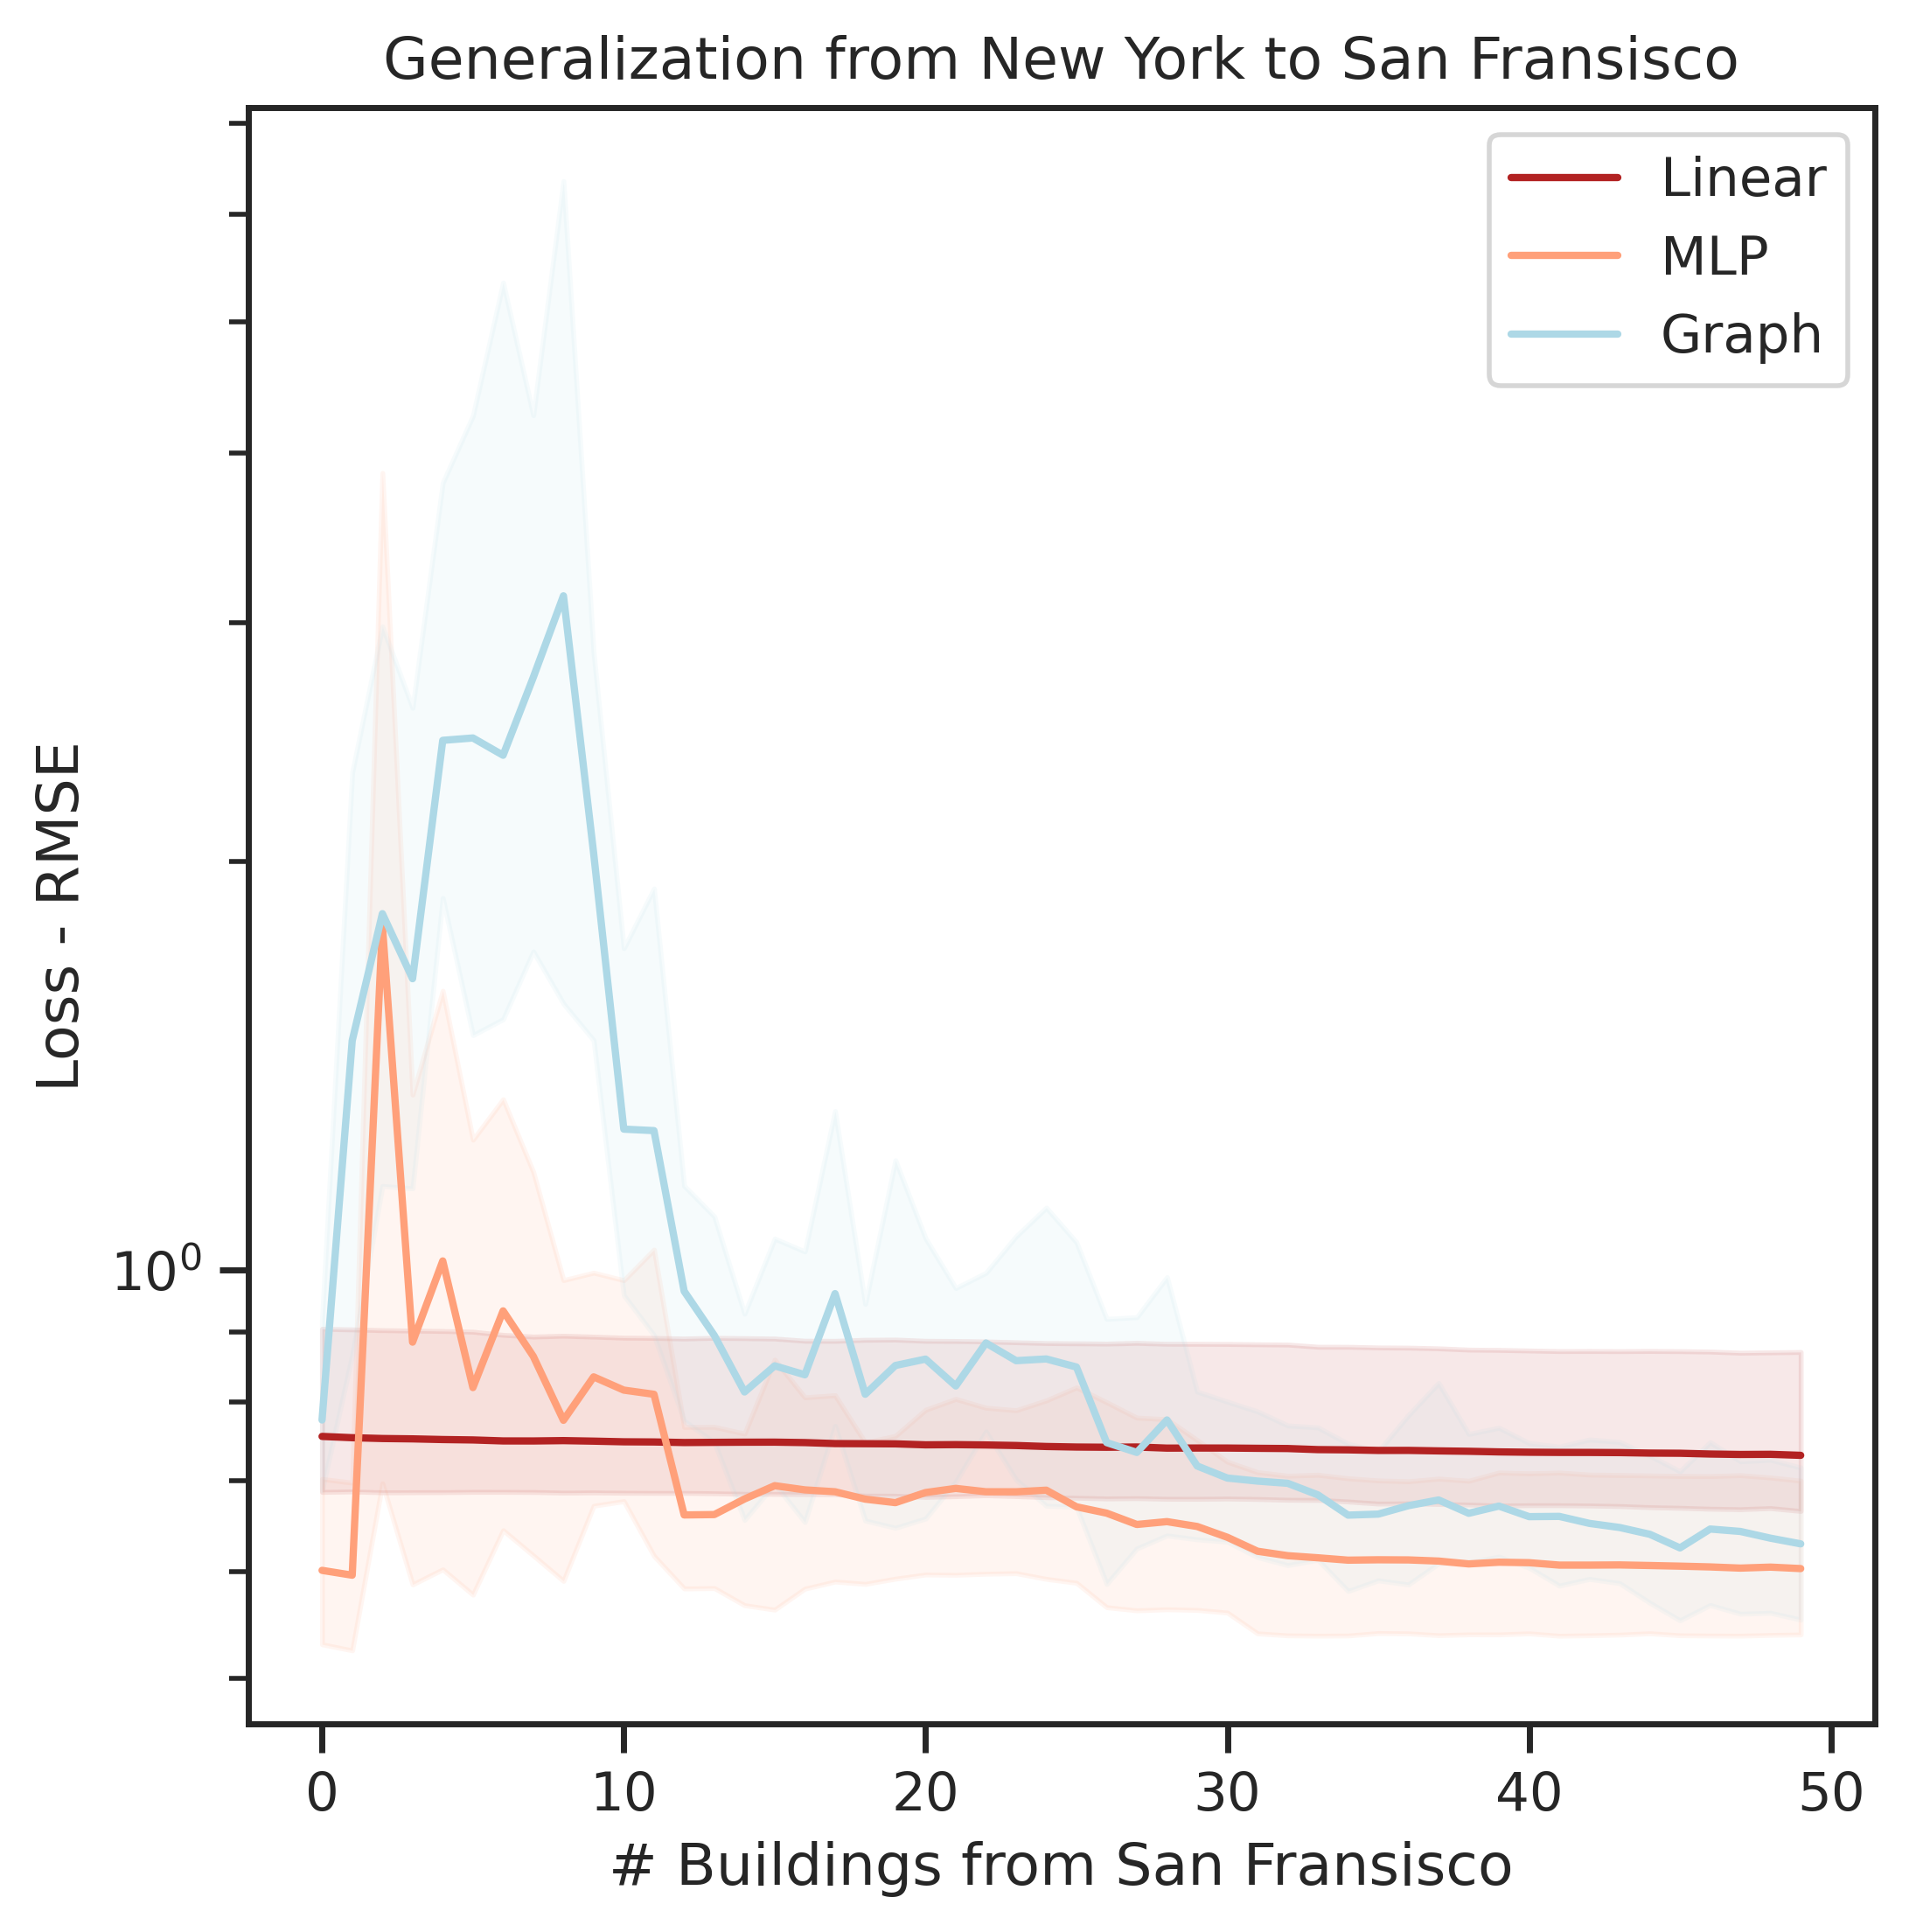

In [224]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(6, 6), dpi=400)

# plt.plot(sf_linearvalloss, label="Linear", color="coral")
# plt.plot(np.percentile(sf_nullvalloss, 5, axis=1), label="MLP", color="orange")
# plt.plot(np.percentile(sf_valloss, 2, axis=1), label="Graph", color="lightblue")
lower = 5
upper = 95

plt.plot(sf_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(sf_linearvalloss.shape[0]), 
    np.percentile(sf_linearvalloss, lower, axis=1), 
    np.percentile(sf_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(sf_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(sf_nullvalloss.shape[0]), 
    np.percentile(sf_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(sf_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(sf_valloss.shape[0]), 
    np.percentile(sf_valloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend()
plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to San Fransisco")
plt.xlabel("# Buildings from San Fransisco")
plt.ylabel("Loss - RMSE")

# plt.ylim((0.5,1.0))

plt.savefig(os.path.join(results_dir, 'sf_generalization.png'))
plt.show()

In [148]:
g3train = copy.deepcopy((g3a['training_mask']).cpu().numpy())
np.random.shuffle(g3train)

g3test = ~g3train

In [189]:
from tqdm import tqdm_notebook

# now exploring how the model might generalize to SF
austin_linearvalloss = []
austin_valloss = []
austin_nullvalloss = []

config['epochs'] = 300

for n_true in tqdm_notebook(range(50), leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(generalization_cv):
        np.random.seed(cv)
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)

        austin_trainmask = copy.deepcopy(g3a['training_mask'].cpu().numpy())
        np.random.shuffle(austin_trainmask)

        austin_testmask = ~austin_trainmask
        austin_to_false = np.where(austin_trainmask)[0]
        austin_to_false

        drip_idx = np.random.choice(austin_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        austin_trainmask = np.repeat([False], len(austin_trainmask))
        austin_trainmask[drip_idx] = True

        rebuild_idx = np.array(g3a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g3['footprint'].x[austin_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g3['footprint'].y[austin_trainmask].cpu().detach()), axis=None)

        reg = LinearRegression().fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g3['footprint'].x[austin_testmask].cpu().detach())
        existing_terms = g3['footprint'].y[austin_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        austin_state_dict, austin_trainlosses, austin_testlosses = trainer(
            model.to(device),
            lambda: model(g3.x_dict, g3.edge_index_dict),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, austin_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g3['footprint'].x),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(austin_testlosses)
        nullmodelcv_loss.append(austin_nulltestlosses)
        
    austin_linearvalloss.append(linearcv_loss)
    austin_valloss.append(modelcv_loss)
    austin_nullvalloss.append(nullmodelcv_loss)
        
austin_linearvalloss = np.array(austin_linearvalloss)
austin_valloss = np.array(austin_valloss)
austin_nullvalloss = np.array(austin_nullvalloss)

/tmp/ipykernel_5440/3334767951.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n_true in tqdm_notebook(range(50), leave=True):


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

In [191]:
austin_valloss.mean(axis=1).min(axis=0).shape

(300,)

In [192]:
austin_nullvalloss.min(axis=2).shape

(50, 5)

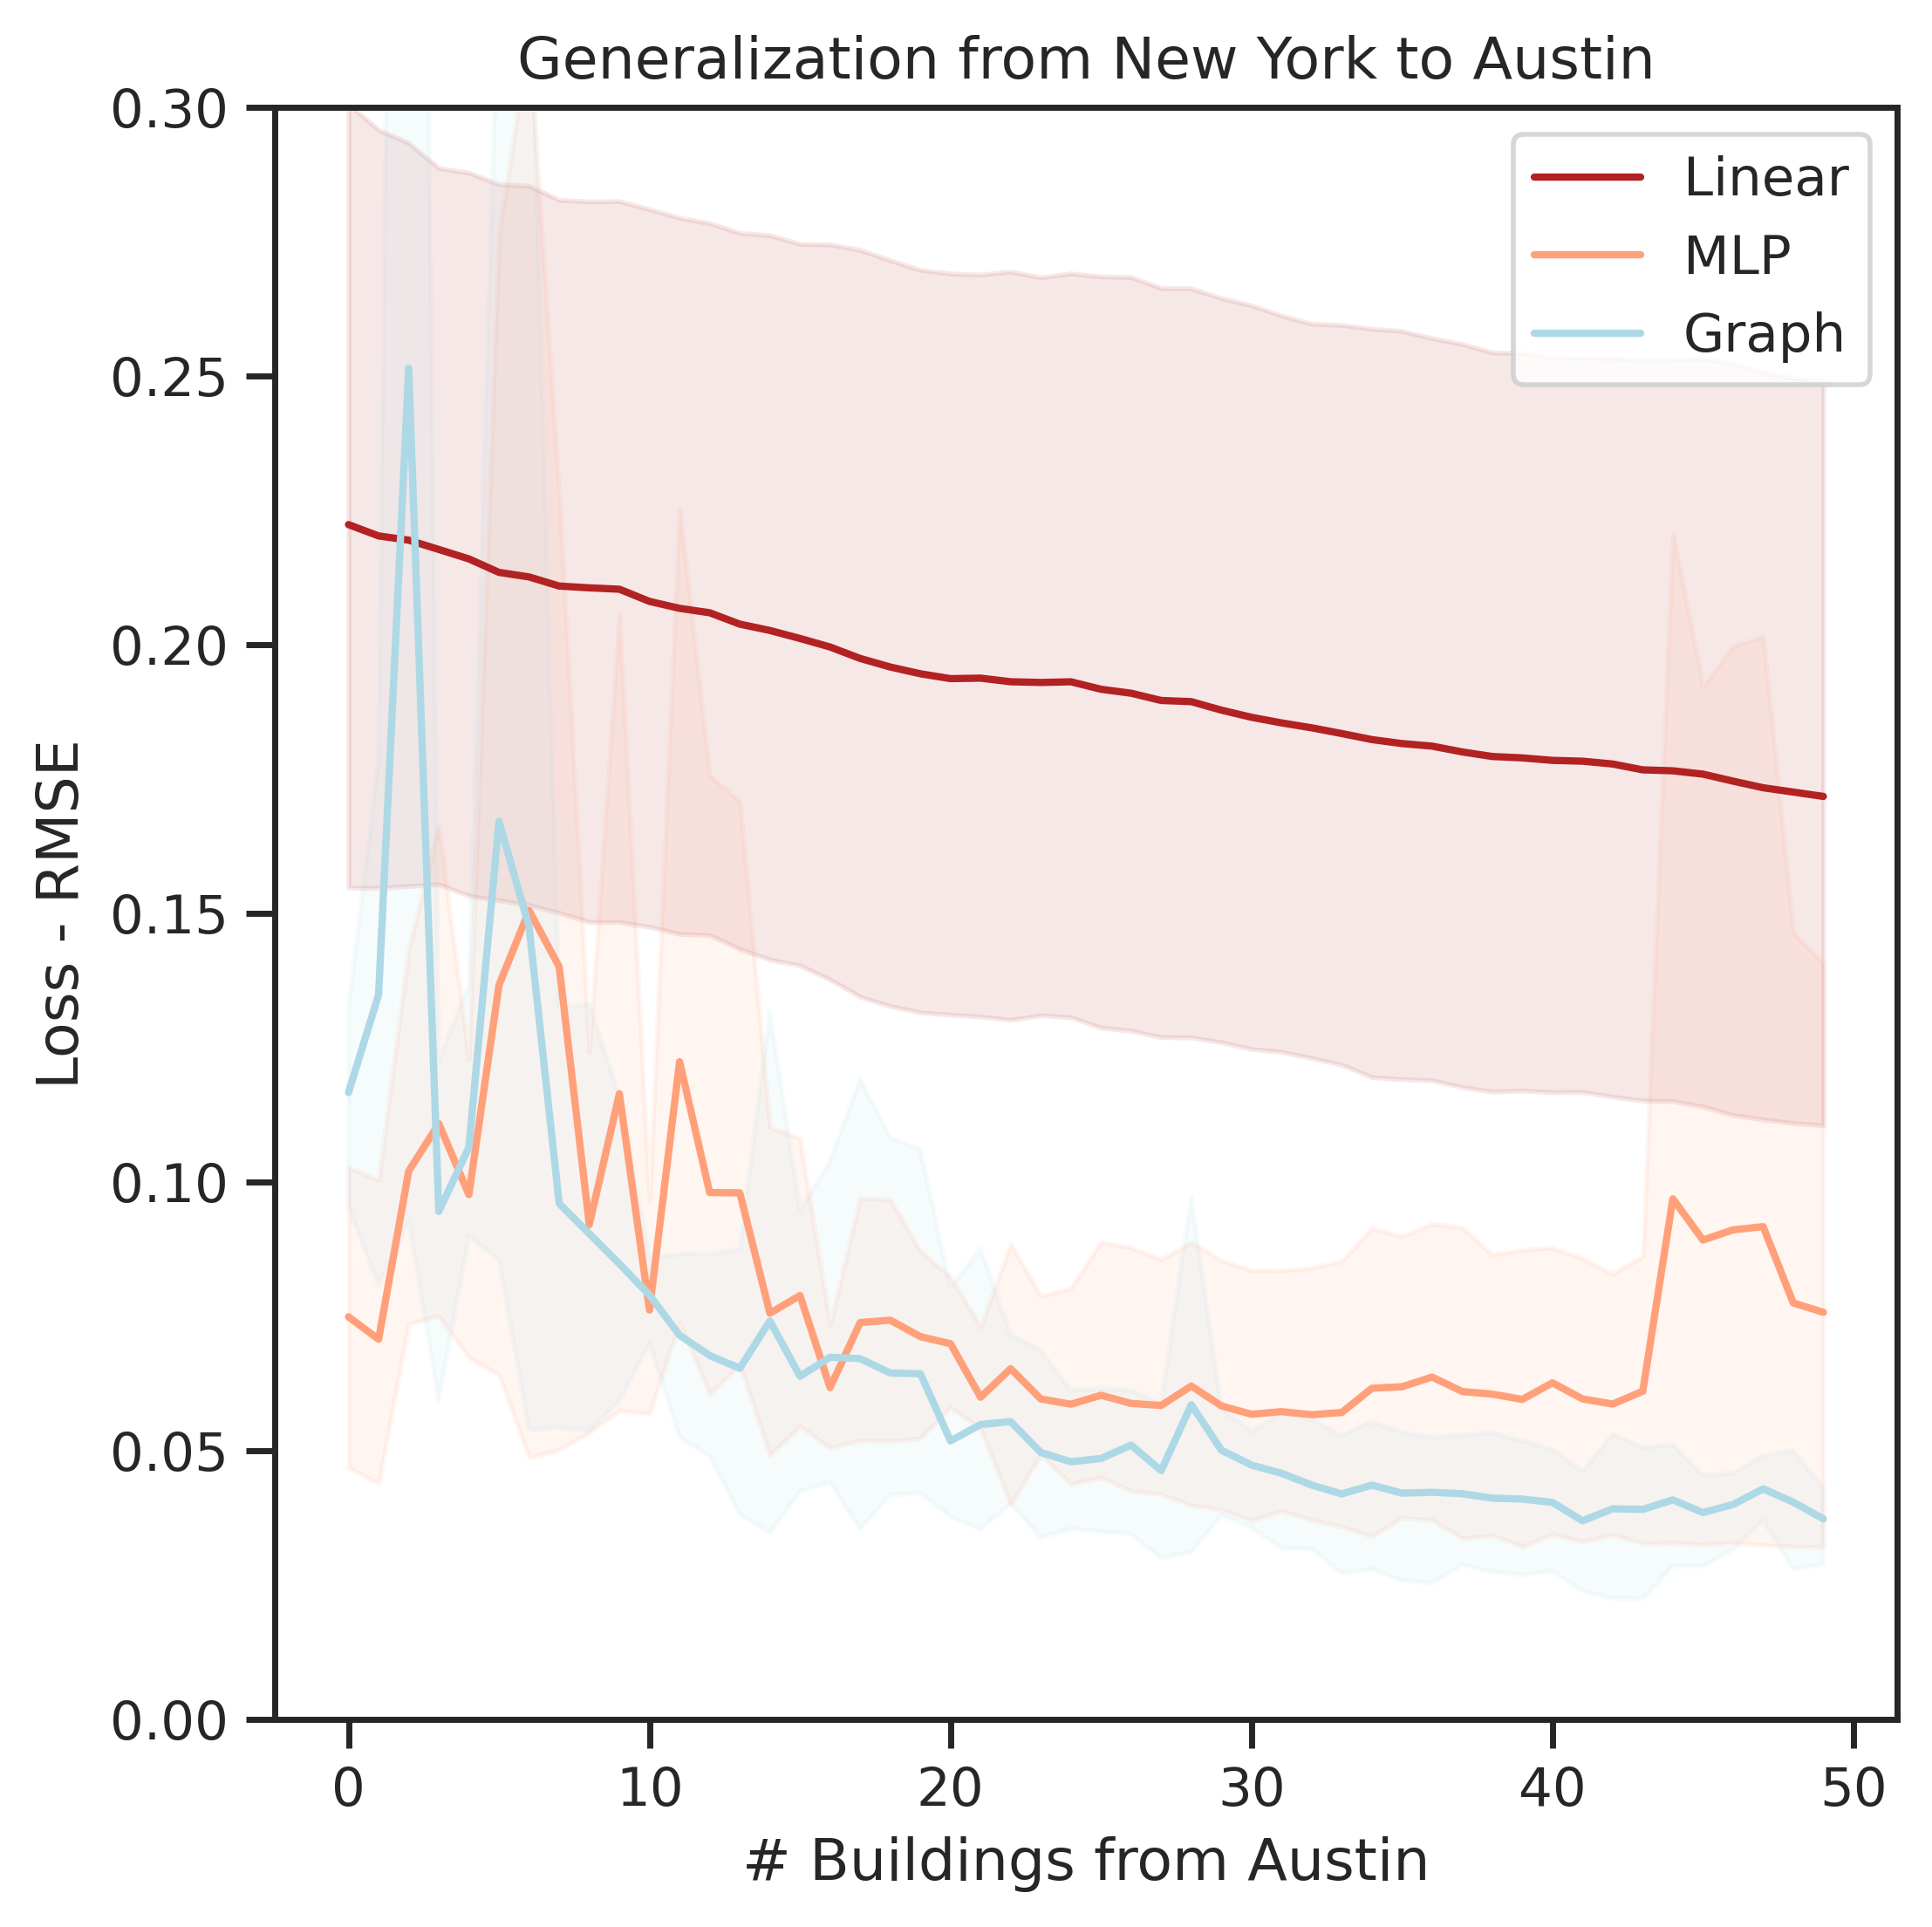

In [227]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(6, 6), dpi=400)

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
# plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")

plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(austin_linearvalloss.shape[0]), 
    np.percentile(austin_linearvalloss, lower, axis=1), 
    np.percentile(austin_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(austin_nullvalloss.shape[0]), 
    np.percentile(austin_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(austin_valloss.shape[0]), 
    np.percentile(austin_valloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend()
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to Austin")
plt.xlabel("# Buildings from Austin")
plt.ylabel("Loss - RMSE")

plt.ylim((0,0.3))
plt.savefig(os.path.join(results_dir, 'austin_generalization.png'))

plt.show()

In [ ]:
# ookaaay now I want to see how the model might generalize

In [ ]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))